In [17]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil import parser

print(pd.__version__)

1.5.2


In [18]:
#%% Projection
#import os
#os.environ['PROJ_LIB'] = 'C:\\Users\\noo029\\Anaconda3\\envs\\py310\\Library\\share\\proj'
#os.environ['GDAL_DATA'] = 'C:\\Users\\noo029\\Anaconda3\\envs\\py310\\Library\\share'


In [19]:
def get_loupe_header(loupe_fn, header_line_num):
    with open(loupe_fn, 'r') as f:
        lines = f.readlines()
        loupe_header = lines[header_line_num].split() 
    return loupe_header

File names: Loupe and Catalyst

In [20]:
loupe_fn = '20240916_mallee_cliffs.dat' # 'Kartoo_2024_02_13.dat'
catalyst_fn = '2024_09_17_Catalyst_Loupe_MalleeCliffs.csv'# '2024-02-13-Kartoo.csv'
epsg_loupe = "EPSG:32754"
epsg_catalyst = "EPSG:7854"


Read in Loupe data

In [21]:

header_line_num = 6

with open(loupe_fn, 'r') as f:
    lines = f.readlines()
    full_loupe_header = lines[0:header_line_num] 

loupe_full_df = (pd.read_csv(loupe_fn, skiprows=7, delim_whitespace=True, header=None, 
                        names=get_loupe_header(loupe_fn, header_line_num))
            .dropna(how='all')
            .dropna())

loupe_df = (pd.read_csv(loupe_fn, skiprows=7, delim_whitespace=True, header=None, 
                       names=get_loupe_header(loupe_fn, header_line_num))
            .dropna(subset=['TIME', 'EAST', 'NORTH', 'HEIGHT'], how='any')
            [['TIME', 'EAST', 'NORTH', 'HEIGHT', 'C']]
            .assign(TIME=lambda df: pd.to_datetime(df['TIME'], format='ISO8601'),
                    EAST=lambda df: pd.to_numeric(df['EAST'], errors='coerce'),
                    NORTH=lambda df: pd.to_numeric(df['NORTH'], errors='coerce'),
                    HEIGHT=lambda df: pd.to_numeric(df['HEIGHT'], errors='coerce'))
            .dropna(how='all')
            .rename(columns={"TIME":'time',
                             'EAST':'x',
                             'NORTH':'y',
                             'HEIGHT':'z'
                            })
            .dropna()
            )

loupeX_df = loupe_df[loupe_df.C == 'X']

loupe_gdf = gpd.GeoDataFrame(
    loupeX_df, 
    geometry=gpd.points_from_xy(loupeX_df['x'], loupeX_df['y']), 
    crs=epsg_loupe)

loupe_gdf ['time'] = loupe_gdf.time.astype(str)

loupe_gdf.to_file(f'{loupe_fn[:-4]}.shp')

loupeX_df = loupeX_df.set_index('time')

print(loupeX_df.head())

                                  x          y     z  C
time                                                   
2024-09-16 07:04:29+00:00  626836.2  6200527.0  43.3  X
2024-09-16 07:04:30+00:00  626836.3  6200527.1  43.3  X
2024-09-16 07:04:31+00:00  626836.4  6200527.2  43.3  X
2024-09-16 07:04:32+00:00  626836.6  6200527.5  43.3  X
2024-09-16 07:04:33+00:00  626837.0  6200528.0  43.3  X


Read in Catalyst data

In [22]:
time_coln, y_coln, x_coln, z_coln = "Gnss DateTime (Local Time)"," Northing(m)"," Easting(m)"," Height MSL(m)"

catalyst_df = pd.read_csv(catalyst_fn)[[time_coln, y_coln, x_coln, z_coln]]   
dt_format = '%d/%m/%Y %I:%M:%S %p (%Z%z)' 
t = catalyst_df[time_coln].tolist()[0]    
print(t)
# check datetime format compatability
try:
    dum = datetime.strptime(t, dt_format)
    print("File datetime format able to be converted!")
except ValueError:
    print(f'Check datetime format in file:{catalyst_fn}')
    exit

# the colons in the "14/09/2023 12:57:27 PM (UTC+12:00)" needs to be removed to allow datetime.strptime to recognise the UTC timezone: https://protect-au.mimecast.com/s/jggLCL7EAOCwrkXAhmfJvX?domain=docs.python.org
#dt_format = '%d/%m/%Y %I:%M:%S %p (%Z%z)'  # 13/02/2024 2:28:03 PM (UTC+10.5:30) -> "14/09/2023 12:57:27 PM (UTC+1200)"   
#catalyst_df[time_coln] = [datetime.strptime(t[:-6]+t[-3:], dt_format) for t in catalyst_df[time_coln]]   
catalyst_df[time_coln] = [datetime.strptime(t, dt_format) for t in catalyst_df[time_coln]]   
print(catalyst_df[time_coln][:10])

catalyst_df = (catalyst_df.assign(time_utc=lambda df: 
                        df[time_coln].dt.tz_convert('UTC'))
                .rename(columns={'time_utc':'time',
                                x_coln:'x', 
                                y_coln:'y', 
                                z_coln:'z'}
                )[['time', 'x', 'y', 'z']]
)

#%% Timestamp analysis
# catalyst_gdf = catalyst_gdf.assign(sec_prev=lambda df: (df['time'].diff().seconds))
nidx = pd.date_range(catalyst_df.time.min(), catalyst_df.time.max(), freq='1s')
catalyst_df = catalyst_df.set_index('time').sort_index()
catalyst_df['raw'] = 'Y' 

catalyst_df_new = catalyst_df.reindex(nidx)
catalyst_df_new[['x', 'y', 'z']] = catalyst_df_new[['x', 'y', 'z']].interpolate()
catalyst_df_new['raw'] = catalyst_df_new['raw'].fillna('interp')

catalyst_gdf_new = gpd.GeoDataFrame(
    catalyst_df_new, 
    geometry=gpd.points_from_xy(catalyst_df_new['x'], catalyst_df_new['y']), 
    crs=epsg_catalyst)
catalyst_gdf_new = catalyst_gdf_new.to_crs(epsg_loupe[4:])

catalyst_df_new['xx'] = catalyst_gdf_new.get_coordinates()['x'].values
catalyst_df_new['yy'] = catalyst_gdf_new.get_coordinates()['y'].values


catalyst_gdf_new['datetime'] = catalyst_gdf_new.index.astype(str)
catalyst_gdf_new = catalyst_gdf_new.reset_index(drop=True)
catalyst_gdf_new.to_file(f'{catalyst_fn[:-4]}.shp')

16/9/2024 4:54:28 pm (UTC+1000)
File datetime format able to be converted!
0   2024-09-16 16:54:28+10:00
1   2024-09-16 16:54:53+10:00
2   2024-09-16 16:54:57+10:00
3   2024-09-16 16:54:59+10:00
4   2024-09-16 17:01:13+10:00
5   2024-09-16 17:01:15+10:00
6   2024-09-16 17:01:16+10:00
7   2024-09-16 17:01:18+10:00
8   2024-09-16 17:01:21+10:00
9   2024-09-16 17:01:24+10:00
Name: Gnss DateTime (Local Time), dtype: datetime64[ns, UTC]


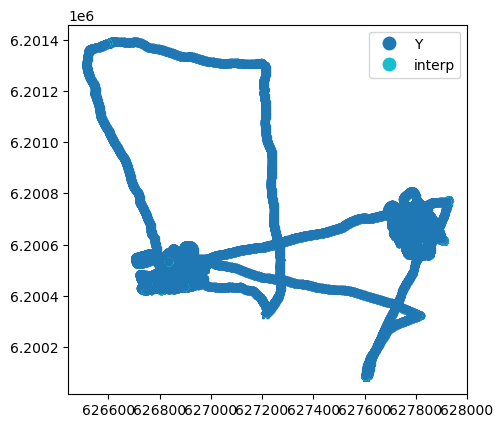

In [23]:
#%% Figure
fig, ax = plt.subplots(1,1)
loupe_gdf.plot(ax=ax, marker='*')
catalyst_gdf_new.plot(ax=ax, column='raw', 
                      marker='o', 
                      edgecolor='none',
                      legend=True)
# cx.add_basemap(ax, crs=catalyst_gdf_new.crs.to_string(), 
#                 source=cx.providers.OpenStreetMap.Mapnik)
plt.show()

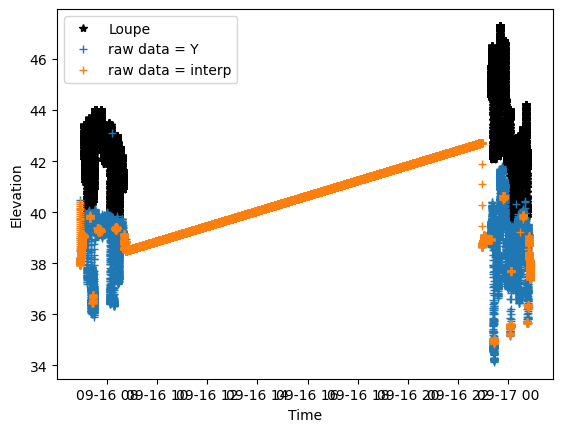

In [24]:
fig, ax = plt.subplots(1,1)
ax.plot(loupe_df.time, loupe_df.z,'k*', label="Loupe")
for idx, grp in catalyst_df_new.groupby('raw'):
    ax.plot(grp.index, grp.z,'+', label=f"raw data = {idx}")
ax.set_xlabel('Time')
ax.set_ylabel('Elevation')
ax.legend()
plt.show()

In [25]:
#%% Concat data sources
df = pd.concat([catalyst_df_new.add_prefix('cata_'), 
                loupeX_df.add_prefix('loupe_')], 
               axis=1)
df['offset_xy'] = ((df['cata_xx'] - df['loupe_x']) ** 2 + (df['cata_yy'] - df['loupe_y']) ** 2) ** 0.5
df.to_csv('loupe_catalyst_combined.dat')

catalyst_df_new = (catalyst_df_new.reset_index(drop=False).rename(columns={'index':'time'}))



In [26]:
#%%
def replace_values(loupe_df, catalyst_df):
    # create a copy of the loupe_df to avoid modifying the original DataFrame
    result_df = loupe_df.copy()
    
    result_df['source'] = 'Loupe'
    # create a lookup table for the catalyst_df and rten_df time columns
    catalyst_lookup = {t: (x, y, z) for t, x, y, z in zip(catalyst_df['time'], 
                                                          catalyst_df['xx'], 
                                                          catalyst_df['yy'], 
                                                          catalyst_df['z'])}
    
    # iterate over the rows in the loupe_df
    for index, row in loupe_df.iterrows():
        # look up the x, y, and z values for the current time in the catalyst_df and rten_df
        x, y, z = catalyst_lookup.get(row['time'], None)
        source = 'Catalyst'
                
        # replace the x, y, and z values in the result_df for the current row
        result_df.at[index, 'x'] = x
        result_df.at[index, 'y'] = y
        result_df.at[index, 'z'] = z
        result_df.at[index, 'source'] = source
       
    return result_df
    
loupe_catalyst_df = replace_values(loupe_df, catalyst_df_new)
loupe_catalyst_df.to_csv('loupe_catalyst_replaced.dat')

loupe_full_df [['EAST', 'NORTH', 'HEIGHT']] = loupe_catalyst_df[['x', 'y', 'z']]
loupe_full_df [['EAST', 'NORTH', 'HEIGHT']] = loupe_full_df [['EAST', 'NORTH', 'HEIGHT']].round(1)

with open(loupe_fn[:-4] + "_catalyst_fix.dat", 'w') as f:
    f.write("".join(full_loupe_header))
    f.write(loupe_full_df.to_string(index=False))